In [1]:
!pip install torch torchvision timm tensorflow tensorflow-hub


  Using cached torchvision-0.22.1-cp310-cp310-win_amd64.whl (1.7 MB)
     ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
     - -------------------------------------- 0.1/2.5 MB 2.6 MB/s eta 0:00:01
     ---- ----------------------------------- 0.3/2.5 MB 2.8 MB/s eta 0:00:01
     ------- -------------------------------- 0.5/2.5 MB 3.7 MB/s eta 0:00:01
     -------- ------------------------------- 0.5/2.5 MB 3.2 MB/s eta 0:00:01
     --------- ------------------------------ 0.6/2.5 MB 3.2 MB/s eta 0:00:01
     ----------- ---------------------------- 0.7/2.5 MB 2.9 MB/s eta 0:00:01
     --------------- ------------------------ 1.0/2.5 MB 3.2 MB/s eta 0:00:01
     ---------------- ----------------------- 1.0/2.5 MB 3.2 MB/s eta 0:00:01
     ------------------ --------------------- 1.2/2.5 MB 3.1 MB/s eta 0:00:01
     -------------------- ------------------- 1.3/2.5 MB 3.2 MB/s eta 0:00:01
     ---------------------- ----------------- 1.4/2.5 MB 3.2 MB/s eta 0:00:01
  


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import timm
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder("skin_split_keras/train", transform=transform)
val_dataset = datasets.ImageFolder("skin_split_keras/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Load MobileViT model
model = timm.create_model('mobilevit_s', pretrained=True, num_classes=2)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Training loop
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    # Validation loop
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_acc = 100 * correct_val / total_val

    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")


# Save
torch.save(model.state_dict(), "mobilevit_s.pth")


d:\cancer\cenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1 - Loss: 0.4333, Train Acc: 80.54%, Val Acc: 86.59%
Epoch 2 - Loss: 0.2688, Train Acc: 89.07%, Val Acc: 88.20%
Epoch 3 - Loss: 0.1991, Train Acc: 92.63%, Val Acc: 88.43%
Epoch 4 - Loss: 0.1406, Train Acc: 94.81%, Val Acc: 89.54%
Epoch 5 - Loss: 0.0930, Train Acc: 96.77%, Val Acc: 89.54%
Epoch 6 - Loss: 0.0732, Train Acc: 97.44%, Val Acc: 87.76%
Epoch 7 - Loss: 0.0542, Train Acc: 98.13%, Val Acc: 88.37%
Epoch 8 - Loss: 0.0529, Train Acc: 98.20%, Val Acc: 90.04%
Epoch 9 - Loss: 0.0337, Train Acc: 98.83%, Val Acc: 88.76%
Epoch 10 - Loss: 0.0238, Train Acc: 99.23%, Val Acc: 89.71%


In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Default threshold = 0.5
preds = (all_probs >= 0.5).astype(int)

# Metrics
acc = accuracy_score(all_labels, preds)
prec = precision_score(all_labels, preds)
rec = recall_score(all_labels, preds)
f1 = f1_score(all_labels, preds)
auc = roc_auc_score(all_labels, all_probs)
cm = confusion_matrix(all_labels, preds)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)
print("AUC:", auc)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(all_labels, preds))


Accuracy: 0.8970506399554814
Precision: 0.7699115044247787
Recall: 0.7092391304347826
F1-score: 0.7383309759547383
AUC: 0.9286974777132079
Confusion Matrix:
 [[1351   78]
 [ 107  261]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      1429
           1       0.77      0.71      0.74       368

    accuracy                           0.90      1797
   macro avg       0.85      0.83      0.84      1797
weighted avg       0.89      0.90      0.90      1797



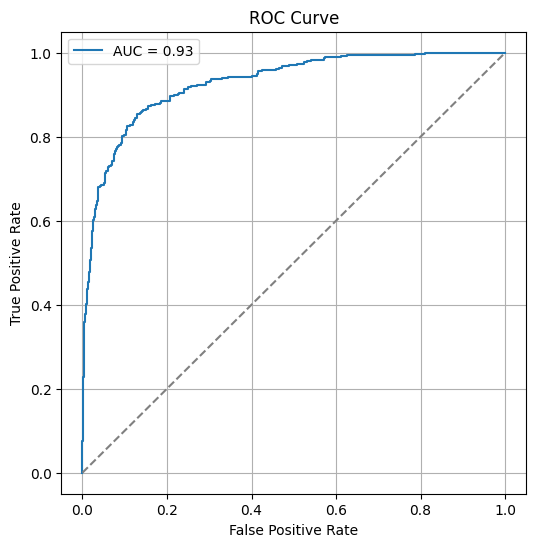

In [3]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


In [5]:
j_scores = tpr - fpr
best_thresh_index = np.argmax(j_scores)
best_threshold = thresholds[best_thresh_index]

print("Best Threshold (Youden's J):", best_threshold)

Best Threshold (Youden's J): 0.026737547


In [6]:
preds_best = (all_probs >= best_threshold).astype(int)
print("Classification Report (Best Threshold):\n", classification_report(all_labels, preds_best))


Classification Report (Best Threshold):
               precision    recall  f1-score   support

           0       0.96      0.87      0.91      1429
           1       0.63      0.85      0.72       368

    accuracy                           0.87      1797
   macro avg       0.79      0.86      0.82      1797
weighted avg       0.89      0.87      0.87      1797




[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


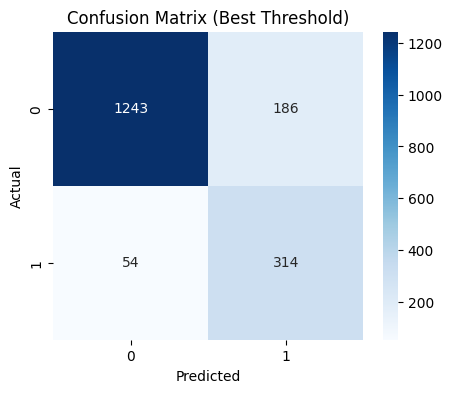

In [7]:
!pip install seaborn
import seaborn as sns
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(all_labels, preds_best), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Best Threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


 Accuracy: 0.9076751946607341
 Precision: 0.8142414860681114
 Recall: 0.7127371273712737
 F1-score: 0.7601156069364162
 AUC: 0.940707489650124

 Confusion Matrix:
 [[1369   60]
 [ 106  263]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94      1429
           1       0.81      0.71      0.76       369

    accuracy                           0.91      1798
   macro avg       0.87      0.84      0.85      1798
weighted avg       0.90      0.91      0.91      1798



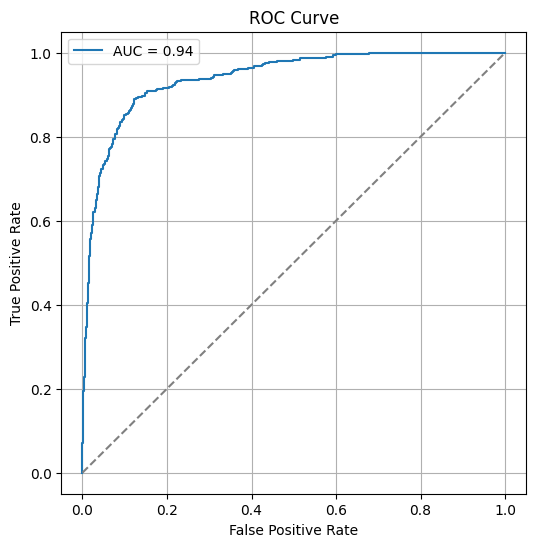

 Best Threshold (Youden's J): 0.0245

 Classification Report (Best Threshold):
               precision    recall  f1-score   support

           0       0.97      0.88      0.92      1429
           1       0.65      0.89      0.75       369

    accuracy                           0.88      1798
   macro avg       0.81      0.88      0.84      1798
weighted avg       0.90      0.88      0.89      1798



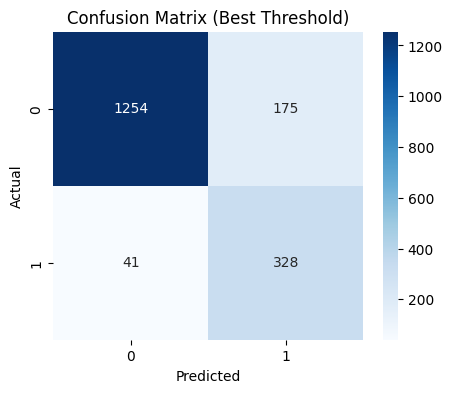

In [8]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ----------------------------
# Load Test Set
# ----------------------------
test_dataset = datasets.ImageFolder("skin_split_keras/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32)

# ----------------------------
# Evaluate on Test Set
# ----------------------------
model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Class 1 probabilities

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# ----------------------------
# Default threshold = 0.5
# ----------------------------
preds = (all_probs >= 0.5).astype(int)

# ----------------------------
# Metrics
# ----------------------------
acc = accuracy_score(all_labels, preds)
prec = precision_score(all_labels, preds)
rec = recall_score(all_labels, preds)
f1 = f1_score(all_labels, preds)
auc = roc_auc_score(all_labels, all_probs)
cm = confusion_matrix(all_labels, preds)

print(" Accuracy:", acc)
print(" Precision:", prec)
print(" Recall:", rec)
print(" F1-score:", f1)
print(" AUC:", auc)
print("\n Confusion Matrix:\n", cm)
print("\n Classification Report:\n", classification_report(all_labels, preds))

# ----------------------------
# ROC Curve
# ----------------------------
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# ----------------------------
# Best Threshold (Youden’s J statistic)
# ----------------------------
j_scores = tpr - fpr
best_thresh_index = np.argmax(j_scores)
best_threshold = thresholds[best_thresh_index]
print(f" Best Threshold (Youden's J): {best_threshold:.4f}")

# ----------------------------
# Recalculate Metrics with Best Threshold
# ----------------------------
preds_best = (all_probs >= best_threshold).astype(int)
print("\n Classification Report (Best Threshold):\n", classification_report(all_labels, preds_best))

# ----------------------------
# Confusion Matrix Visualization
# ----------------------------
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(all_labels, preds_best), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Best Threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


CONVERTING TO TFLITE

In [12]:
import torch
import timm

model = timm.create_model('mobilevit_s', pretrained=False, num_classes=2)
model.load_state_dict(torch.load("mobilevit_s.pth", map_location=torch.device('cpu')))
model.eval()

dummy_input = torch.randn(1, 3, 224, 224)


torch.onnx.export(
    model,
    dummy_input,
    "mobilevit_s.onnx",
    input_names=["input"],
    output_names=["output"],
    opset_version=16
)


In [9]:
!pip install onnx onnx-tf

     ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
     --------------------------------------- 0.1/15.8 MB 919.0 kB/s eta 0:00:18
      --------------------------------------- 0.2/15.8 MB 1.8 MB/s eta 0:00:09
      --------------------------------------- 0.3/15.8 MB 2.0 MB/s eta 0:00:08
     - -------------------------------------- 0.6/15.8 MB 2.6 MB/s eta 0:00:06
     - -------------------------------------- 0.8/15.8 MB 2.9 MB/s eta 0:00:06
     -- ------------------------------------- 1.0/15.8 MB 3.4 MB/s eta 0:00:05
     -- ------------------------------------- 1.2/15.8 MB 3.2 MB/s eta 0:00:05
     --- ------------------------------------ 1.4/15.8 MB 3.6 MB/s eta 0:00:05
     ---- ----------------------------------- 1.6/15.8 MB 3.7 MB/s eta 0:00:04
     ---- ----------------------------------- 1.8/15.8 MB 3.6 MB/s eta 0:00:04
     ----- ---------------------------------- 2.0/15.8 MB 4.0 MB/


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
%pip install --upgrade onnx-tf tensorflow keras tensorflow-probability

import onnx
import torch
import tensorflow as tf
import onnx_tf

onnx_model = onnx.load("mobilevit_s.onnx")
# tf_model = prepare(onnx_model)
# tf_model.export_graph("mobilevit_tf")



# Convert the ONNX model to TensorFlow format
tf_model_path = 'mobilevit_s.pb'
tf_rep = onnx_tf.backend.prepare(onnx_model)
tf_rep.export_graph(tf_model_path)

# Convert the TensorFlow model to TensorFlow Lite format
converter = tf.compat.v1.lite.TFLiteConverter.from_saved_model(tf_model_path)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('mobileVit.tflite', 'wb') as f:
    f.write(tflite_model)


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


ModuleNotFoundError: No module named 'keras.src.engine'

In [ ]:
!pip install tensorflow tensorflow-hub
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model("mobilevit_tf")
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional
tflite_model = converter.convert()

with open("mobilevit_s.tflite", "wb") as f:
    f.write(tflite_model)
